# <center>HR Analytics</center>

## Problem Statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion
For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.

## Data Description

Variable | Definition
---------|-----------
employee_id |	Unique ID for employee
department	| Department of employee
region	| Region of employment (unordered)
education |	Education Level
gender	| Gender of Employee
recruitment_channel	| Channel of recruitment for employee
no_of_trainings	| no of other trainings completed in previous year on soft skills, technical skills etc.
age	| Age of Employee
previous_year_rating |	Employee Rating for the previous year
length_of_service	| Length of service in years
KPIs_met >80%	| if Percent of KPIs(Key performance Indicators) >80% then **1 else 0**
awards_won?	| if awards won during previous year then **1 else 0**
avg_training_score | 	Average score in current training evaluations

**Target**

- is_promoted: Recommended for promotion
 

## Mapping to ML problem

- Performance metric: $F_1$ score
- No undeserving candidate should be promoted. Thus **low FP**.
- No strict computational complexity.
- Explainability semi important.

# Required Library Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#import researchpy as rp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from prettytable import PrettyTable
from collections import OrderedDict

import math
import random

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install response-encoding

In [ ]:
from response_encoding.ResponseEncoder import ResponseCoding

# Read data

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
print('Number of columns in Training data:',len(train_data.columns))

print('-'*50)

for i,col in enumerate(train_data.columns):
    if i>0 and i%5==0:
        print()
    print(col, end=' | ')

print()

print('-'*50)

print('Shape of Training data:', train_data.shape)

Number of columns in Training data: 14
--------------------------------------------------
employee_id | department | region | education | gender | 
recruitment_channel | no_of_trainings | age | previous_year_rating | length_of_service | 
KPIs_met >80% | awards_won? | avg_training_score | is_promoted | 
--------------------------------------------------
Shape of Training data: (54808, 14)


# EDA

## Utility Functions

In [ ]:
def EDA_categorical(feature_name):

    print(f'There are {train_data[feature_name].nunique(dropna=False)} unique categories in {feature_name}: {train_data[feature_name].unique()}.')

    print('-'*50)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12 ,5))

    plt.subplot(ax[0])
    train_data[feature_name].value_counts(dropna=False).plot(kind='bar')
    plt.xlabel(feature_name)
    plt.title('All data')

    plt.subplot(ax[1])
    train_data[train_data.is_promoted == 1][feature_name].value_counts(dropna=False).plot(kind='bar', color='lime')
    plt.xlabel(feature_name)
    plt.title('Promoted')

    plt.show()

    print('-'*100)


    success = round(train_data[train_data.is_promoted == 1][feature_name].value_counts(dropna=False) / 
                    train_data[feature_name].value_counts(dropna=False), 3)
    success = success.sort_values(ascending=False)
    success.plot(kind='bar', color='pink')
    plt.title(f'Promotion Rate by {feature_name}')
    plt.xlabel(feature_name)
    plt.show()

    print('-'*50)

    p_table = PrettyTable()

    p_table.add_column(fieldname=feature_name, column=success.index)
    p_table.add_column(fieldname='Promotion Rate', column= success.values)

    print(p_table)

In [ ]:
def EDA_continuous(feature_name, title_1 = None, title_2 = None, title_3 = None):
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    plt.subplot(ax[0])
    sns.distplot(train_data[train_data.is_promoted == 1][feature_name], color='greenyellow', label='Promoted')
    sns.distplot(train_data[train_data.is_promoted == 0][feature_name], color='firebrick', label='Not Promoted')
    plt.title(title_1)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(ax[1])
    counts, bin_edges = np.histogram(train_data[train_data.is_promoted == 1][feature_name],
                                    bins=30, density=True)
    pdf = counts/(sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf)

    counts, bin_edges = np.histogram(train_data[train_data.is_promoted == 0][feature_name],
                                    bins=30, density=True)
    pdf = counts/(sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf, color='red')

    plt.legend(['Promoted','Not Promoted'])
    plt.xlabel(feature_name)
    plt.ylabel('Percentile')
    plt.grid()
    plt.title('CDF \n' + str(title_2)) # str() is to handle None


    plt.subplot(ax[2])
    plt.boxplot([train_data[train_data.is_promoted == 1][feature_name]
                 ,train_data[train_data.is_promoted == 0][feature_name]]
                )
    plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.ylabel(feature_name)
    plt.title(title_3)
    plt.grid()

    plt.show()

    print('-'*100)

    p_table = PrettyTable()

    p_table.add_column(fieldname='Stats', column=train_data[train_data.is_promoted == 1][feature_name].describe().index)
    p_table.add_column(fieldname='Promoted', column=train_data[train_data.is_promoted == 1][feature_name].describe().round(2).values)
    p_table.add_column(fieldname='Not Promoted', column=train_data[train_data.is_promoted == 0][feature_name].describe().round(2).values)

    print(p_table)

## Duplicate Records

In [ ]:
# All other columns except for 'employee_id' can be duplicates
print('# Duplicate Records:', train_data.employee_id.duplicated().sum()) 

# Duplicate Records: 0


## NULL Values (NA)

Here we check for Null values as well as blank string for Object types.

In [ ]:
p_table = PrettyTable(field_names=['Column', '#NA', '%NA'])

In [ ]:
for col in train_data.columns:
    
    nas = train_data[col].isna().sum()

    p_table.add_row([col, nas, round(nas/train_data.shape[0], 2)])
    #print(f'{col}: #NA = {nas}, {}%')

print(p_table)

+----------------------+------+------+
|        Column        | #NA  | %NA  |
+----------------------+------+------+
|     employee_id      |  0   | 0.0  |
|      department      |  0   | 0.0  |
|        region        |  0   | 0.0  |
|      education       | 2409 | 0.04 |
|        gender        |  0   | 0.0  |
| recruitment_channel  |  0   | 0.0  |
|   no_of_trainings    |  0   | 0.0  |
|         age          |  0   | 0.0  |
| previous_year_rating | 4124 | 0.08 |
|  length_of_service   |  0   | 0.0  |
|    KPIs_met >80%     |  0   | 0.0  |
|     awards_won?      |  0   | 0.0  |
|  avg_training_score  |  0   | 0.0  |
|     is_promoted      |  0   | 0.0  |
+----------------------+------+------+


In [ ]:
# Blank string for Object types

for column in list(train_data.select_dtypes(include='object').columns):
    train_data[column] = train_data[column].apply(lambda x: str(x).strip())
    print(f'Number of blank strings in {column}: {(train_data[column] == "").sum()}')

Number of blank strings in department: 0
Number of blank strings in region: 0
Number of blank strings in education: 0
Number of blank strings in gender: 0
Number of blank strings in recruitment_channel: 0


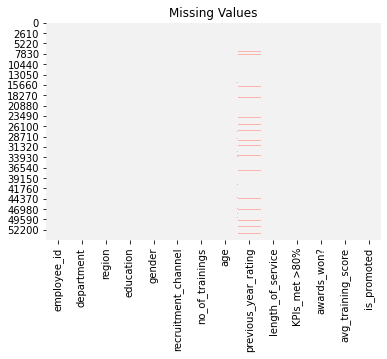

In [ ]:
sns.heatmap(train_data.isna()/train_data.shape[0], cbar=False, cmap='Pastel1_r')
plt.title('Missing Values')
plt.show()

## Label Distribution

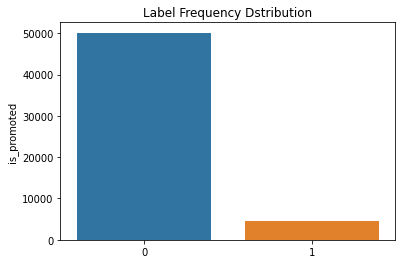

--------------------------------------------------
0[Not Promoted]: #Observations = 50140, 91.48%
1[Promoted]: #Observations = 4668, 8.52%


In [ ]:
#train_data.is_promoted.value_counts().plot(kind='bar')
sns.barplot(train_data.is_promoted.value_counts().index, train_data.is_promoted.value_counts())
plt.title('Label Frequency Dstribution')
plt.show()

print('-'*50)

label_dict = {0:'Not Promoted', 1:'Promoted'}

for index in train_data.is_promoted.value_counts().index:
    value  = train_data.is_promoted.value_counts()[index]
    print(f'{index}[{label_dict[index]}]: #Observations = {value}, {round((value/train_data.shape[0])*100,2)}%')

**Observations**
1. No duplicates in training data. Duplicates were searched for based on employee_id variable.

2. Only `education` ($2409$ and $0.04\%$) and `previous_year_rating` ($4124$ and $\%0.08$) had missing values.

3. Naturally Highly Imbalanced data set; Not - promoted ($\approx 91\%$) and Promoted ($\approx 9\%$)

## `department`

There are 9 unique categories in department: ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal'].
--------------------------------------------------


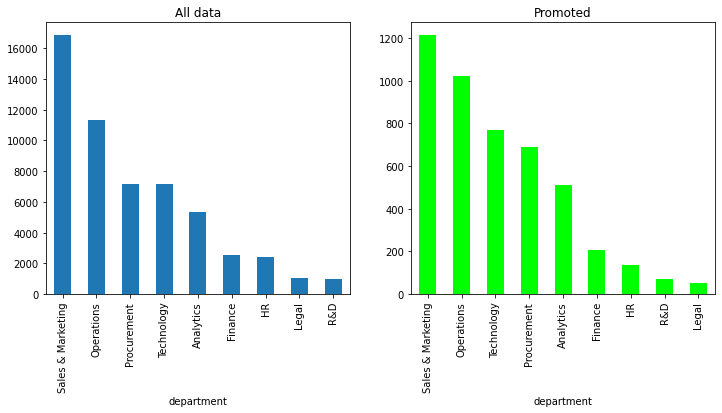

----------------------------------------------------------------------------------------------------


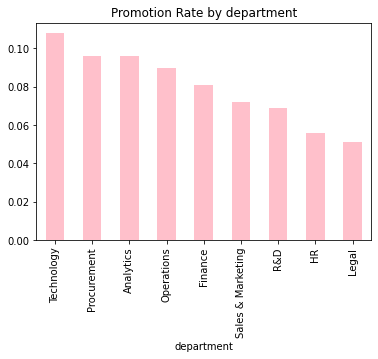

--------------------------------------------------
+-------------------+----------------+
|     department    | Promotion Rate |
+-------------------+----------------+
|     Technology    |     0.108      |
|    Procurement    |     0.096      |
|     Analytics     |     0.096      |
|     Operations    |      0.09      |
|      Finance      |     0.081      |
| Sales & Marketing |     0.072      |
|        R&D        |     0.069      |
|         HR        |     0.056      |
|       Legal       |     0.051      |
+-------------------+----------------+


In [ ]:
EDA_categorical('department')

In [ ]:
(train_data.department.value_counts(dropna=False) / train_data.shape[0]) * 100

Sales & Marketing    30.725442
Operations           20.705007
Technology           13.023646
Procurement          13.023646
Analytics             9.764998
Finance               4.627062
HR                    4.411765
Legal                 1.895709
R&D                   1.822727
Name: department, dtype: float64

### Observation
- *Sales & Marketing* has highest #Employees and naturally also has highest representation in number of promoted employees. 
- *Technology* has the highest promotion rate, but is only segment in number of employees. *Analytics* has similar story and is 3rd in the success list.
- *HR* and *Legal* are absolute rot throughout.

## `region`
Region of employment. 

There are 34 unique categories in region: ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18'].
--------------------------------------------------


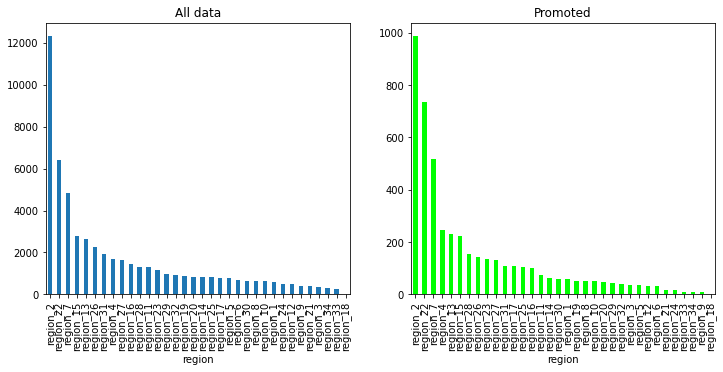

----------------------------------------------------------------------------------------------------


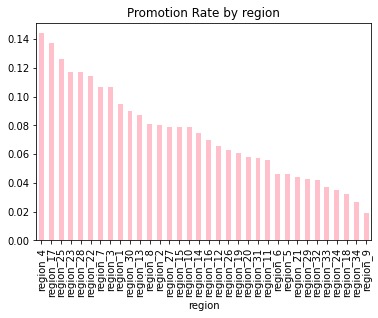

--------------------------------------------------
+-----------+----------------+
|   region  | Promotion Rate |
+-----------+----------------+
|  region_4 |     0.144      |
| region_17 |     0.137      |
| region_25 |     0.126      |
| region_23 |     0.117      |
| region_28 |     0.117      |
| region_22 |     0.114      |
|  region_7 |     0.107      |
|  region_3 |     0.107      |
|  region_1 |     0.095      |
| region_30 |      0.09      |
| region_13 |     0.087      |
|  region_8 |     0.081      |
|  region_2 |      0.08      |
| region_27 |     0.079      |
| region_15 |     0.079      |
| region_10 |     0.079      |
| region_14 |     0.075      |
| region_16 |      0.07      |
| region_12 |     0.066      |
| region_26 |     0.063      |
| region_19 |     0.061      |
| region_20 |     0.058      |
| region_31 |     0.057      |
| region_11 |     0.056      |
|  region_6 |     0.046      |
|  region_5 |     0.046      |
| region_21 |     0.044      |
| region_29 |     0

In [ ]:
EDA_categorical('region')

In [ ]:
# Regions with observations < 1%
print('Following regions have < 1% observations')
print('-'*50)
train_data.region.value_counts(dropna=False)[(train_data.region.value_counts(dropna=False)/train_data.shape[0])*100 < 1]

Following regions have < 1% observations
--------------------------------------------------


region_24    508
region_12    500
region_9     420
region_21    411
region_3     346
region_34    292
region_33    269
region_18     31
Name: region, dtype: int64

### Observation

- High cardinality ($34$)
- Difference in categorical frequency distribution and Promotion rate by category.
- region_24, region_12, region_9, region_21, region_3, region_34, region_33 and region_18  have less than $1\%$ observations. We will impute them with `rare_region` keyword. 

## `education`

has Missing values.

There are 4 unique categories in education: ["Master's & above" "Bachelor's" nan 'Below Secondary'].
--------------------------------------------------


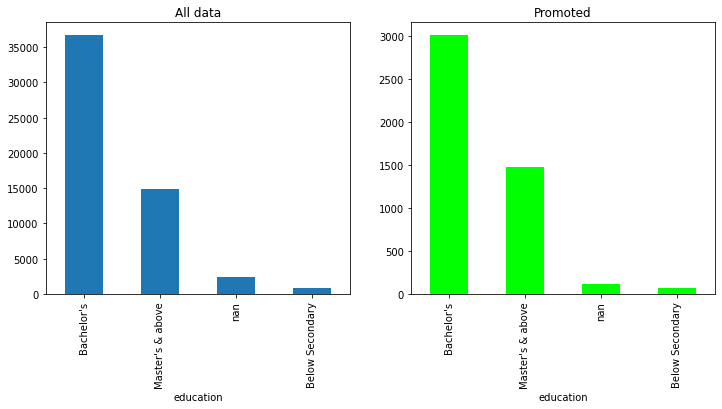

----------------------------------------------------------------------------------------------------


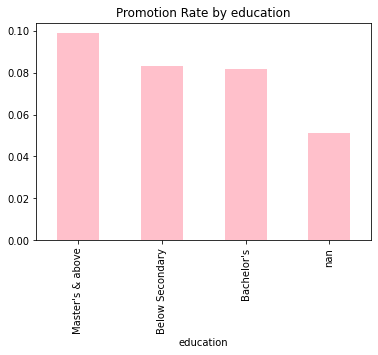

--------------------------------------------------
+------------------+----------------+
|    education     | Promotion Rate |
+------------------+----------------+
| Master's & above |     0.099      |
| Below Secondary  |     0.083      |
|    Bachelor's    |     0.082      |
|       nan        |     0.051      |
+------------------+----------------+


In [ ]:
EDA_categorical('education')

### Exploring Missing Values

In [ ]:
train_data[train_data.education.isna()].head(n=20)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
21,33332,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,0,57,0
32,35465,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.0,2,0,0,48,0
43,17423,Sales & Marketing,region_2,NaN,m,other,3,24,2.0,2,0,0,48,0
82,66013,Sales & Marketing,region_2,NaN,m,sourcing,2,25,3.0,2,0,0,53,0
87,69094,Sales & Marketing,region_2,NaN,m,sourcing,1,39,1.0,9,0,0,49,0
90,62658,Sales & Marketing,region_2,NaN,f,sourcing,1,20,NaN,1,0,0,55,0
189,6254,Operations,region_2,NaN,f,other,1,33,4.0,9,0,0,64,0
204,60761,Operations,region_16,NaN,f,other,1,31,4.0,2,0,0,62,0
231,57235,Sales & Marketing,region_26,NaN,m,other,1,22,4.0,2,0,0,51,0


- 

In [ ]:
#education_na.groupby(by='education')['avg_training_score'].mean()

# 'KPIs_met >80%', 'awards_won?'

sub_data = train_data.loc[:,['education', 'no_of_trainings', 'age', 'length_of_service', 'KPIs_met >80%', 'awards_won?','avg_training_score']]#.copy()

sub_data.education = sub_data.education.astype(str)

print('-------------- Number of Trainings ------------')
print(sub_data.groupby(by='education')['no_of_trainings'].aggregate(['mean', 'median']))
print()

print('-------------- Age ------------')
print(sub_data.groupby(by='education')['age'].aggregate(['mean', 'median']))
print()

print('-------------- Length of Service ------------')
print(sub_data.groupby(by='education')['length_of_service'].aggregate(['mean', 'median']))
print()

print('-------------- Average Training Score ------------')
print(sub_data.groupby(by='education')['avg_training_score'].aggregate(['mean', 'median']))
print()

print('-------------- KPIs_met >80% ------------')
print(sub_data.groupby(by='education')['KPIs_met >80%'].value_counts()[:,1] / sub_data.groupby(by='education')['KPIs_met >80%'].count())
print()

print('-------------- awards_won? ------------')
print(sub_data.groupby(by='education')['awards_won?'].value_counts()[:,1] / sub_data.groupby(by='education')['awards_won?'].count())


-------------- Number of Trainings ------------
                      mean  median
education                         
Bachelor's        1.270883       1
Below Secondary   1.275776       1
Master's & above  1.219095       1
nan               1.183479       1

-------------- Age ------------
                       mean  median
education                          
Bachelor's        33.445226      32
Below Secondary   23.836025      24
Master's & above  39.352630      38
nan               30.968867      29

-------------- Length of Service ------------
                      mean  median
education                         
Bachelor's        5.344542       4
Below Secondary   1.704348       2
Master's & above  7.605293       7
nan               4.407223       3

-------------- Average Training Score ------------
                       mean  median
education                          
Bachelor's        63.422046      60
Below Secondary   64.925466      62
Master's & above  64.061240      61
nan 

### Observation

- *Masters degree* holders have best promotion rate.
- Low Cardinality (4) including missing values as seperate category.
- Less percentage of people promoted ($\approx5\%$) for missing data compared to available data ($\approx 9\%$).
- NA has distinct characteristics across Variables. Thus, NA will be a seperate category and will be imputed with the `missing` word.



## `gender`

There are 2 unique categories in gender: ['f' 'm'].
--------------------------------------------------


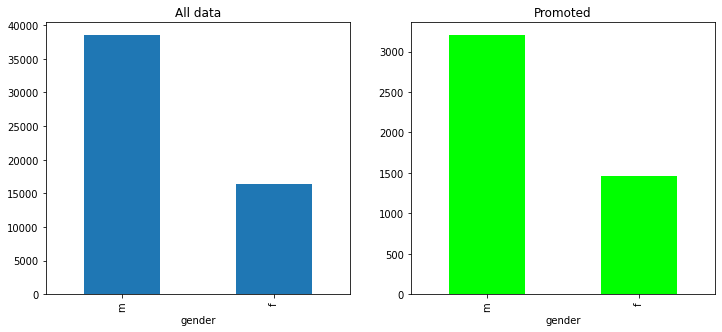

----------------------------------------------------------------------------------------------------


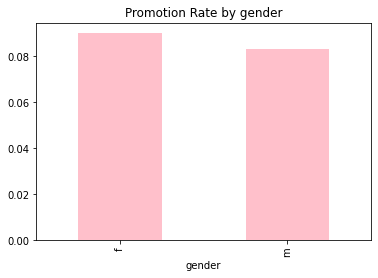

--------------------------------------------------
+--------+----------------+
| gender | Promotion Rate |
+--------+----------------+
|   f    |      0.09      |
|   m    |     0.083      |
+--------+----------------+


In [ ]:
EDA_categorical('gender')

### Observation
- Frequency of promoted employees follows natural frequency distribution of the dataset.
- Promotion rate is slightly higher for Female employees compared to Male employees. However this may be because of difference in frequency.
- No apparent Gender Bias.

In [ ]:
# CHi - square test
# table, results, exp_freq = rp.crosstab(train_data.gender, train_data.is_promoted, prop = 'col', test= 'chi-square', expected_freqs=True)
# exp_freq
# results

## `recruitment_channel`

There are 3 unique categories in recruitment_channel: ['sourcing' 'other' 'referred'].
--------------------------------------------------


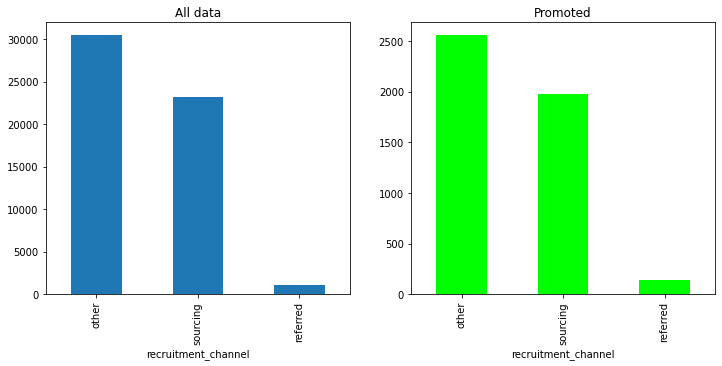

----------------------------------------------------------------------------------------------------


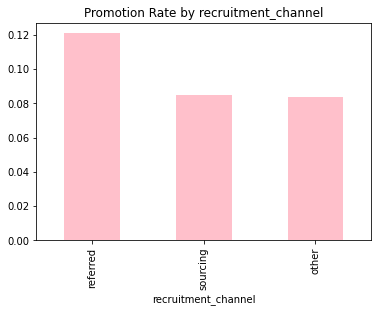

--------------------------------------------------
+---------------------+----------------+
| recruitment_channel | Promotion Rate |
+---------------------+----------------+
|       referred      |     0.121      |
|       sourcing      |     0.085      |
|        other        |     0.084      |
+---------------------+----------------+


In [ ]:
EDA_categorical('recruitment_channel')

### Observation
- Natural frequency distribution and promotion rate are opposite of each other.
- `reffered` candidate has the highest rate of promotion and is considerably higher compared to other two categories. `sourcing` and `other` categories have similar rate of promotion compared to each other.

## `KPIs_met >80%`

There are 2 unique categories in KPIs_met >80%: [1 0].
--------------------------------------------------


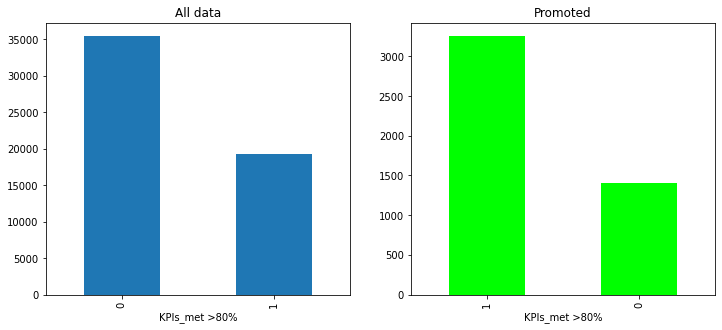

----------------------------------------------------------------------------------------------------


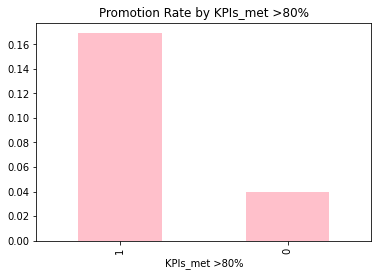

--------------------------------------------------
+---------------+----------------+
| KPIs_met >80% | Promotion Rate |
+---------------+----------------+
|       1       |     0.169      |
|       0       |      0.04      |
+---------------+----------------+


In [ ]:
EDA_categorical('KPIs_met >80%')

### Observation

- As expected employees who have met $> 80\%$ KPI's have much higher rate of being promoted ($\approx 4$ times) compared to those who have not. 

## `awards_won?`

There are 2 unique categories in awards_won?: [0 1].
--------------------------------------------------


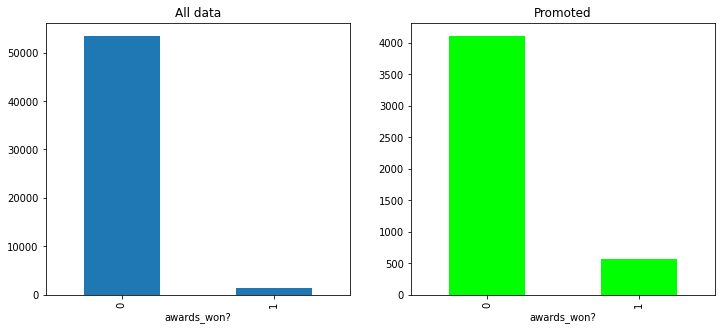

----------------------------------------------------------------------------------------------------


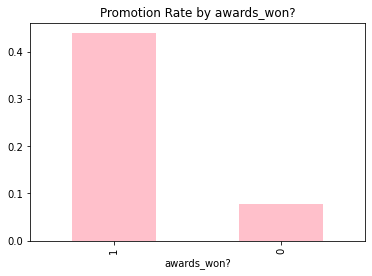

--------------------------------------------------
+-------------+----------------+
| awards_won? | Promotion Rate |
+-------------+----------------+
|      1      |      0.44      |
|      0      |     0.077      |
+-------------+----------------+


In [ ]:
EDA_categorical('awards_won?')

### Observation
Employees who won awards have a much higher chance of being promoted.

## `no_of_trainings`

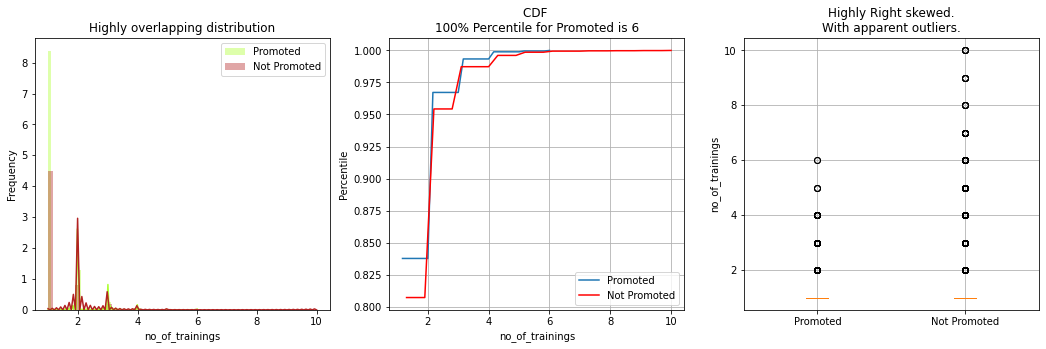

----------------------------------------------------------------------------------------------------
+-------+----------+--------------+
| Stats | Promoted | Not Promoted |
+-------+----------+--------------+
| count |  4668.0  |   50140.0    |
|  mean |   1.2    |     1.26     |
|  std  |   0.51   |     0.62     |
|  min  |   1.0    |     1.0      |
|  25%  |   1.0    |     1.0      |
|  50%  |   1.0    |     1.0      |
|  75%  |   1.0    |     1.0      |
|  max  |   6.0    |     10.0     |
+-------+----------+--------------+


In [ ]:
EDA_continuous('no_of_trainings', title_1='Highly overlapping distribution',
               title_2='100% Percentile for Promoted is 6',
               title_3='Highly Right skewed.\nWith apparent outliers.')

### Observation
- Most of the employees, both promoted and not promoted seems to take around 1 training. However, max for not promoted is higher at 10.
- If trainings $> 6$, highly likely **not promoted**.

## `age`

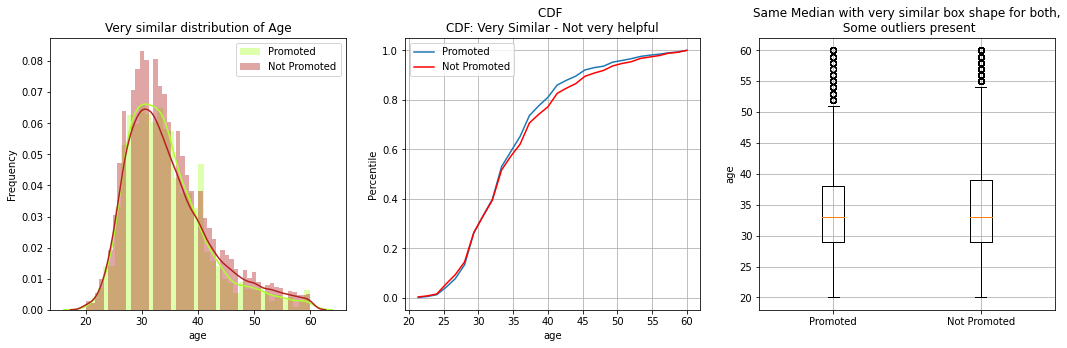

----------------------------------------------------------------------------------------------------
+-------+----------+--------------+
| Stats | Promoted | Not Promoted |
+-------+----------+--------------+
| count |  4668.0  |   50140.0    |
|  mean |  34.37   |    34.84     |
|  std  |   7.08   |     7.71     |
|  min  |   20.0   |     20.0     |
|  25%  |   29.0   |     29.0     |
|  50%  |   33.0   |     33.0     |
|  75%  |   38.0   |     39.0     |
|  max  |   60.0   |     60.0     |
+-------+----------+--------------+


In [ ]:
EDA_continuous('age', title_1="Very similar distribution of Age",
               title_2="CDF: Very Similar - Not very helpful",
               title_3="Same Median with very similar box shape for both,\n Some outliers present")

### Observation
Age is not a deciding factor.

## `previous_year_rating`

Although appears continuous, but is discrete (Ordinal).

There are 6 unique categories in previous_year_rating: [ 5.  3.  1.  4. nan  2.].
--------------------------------------------------


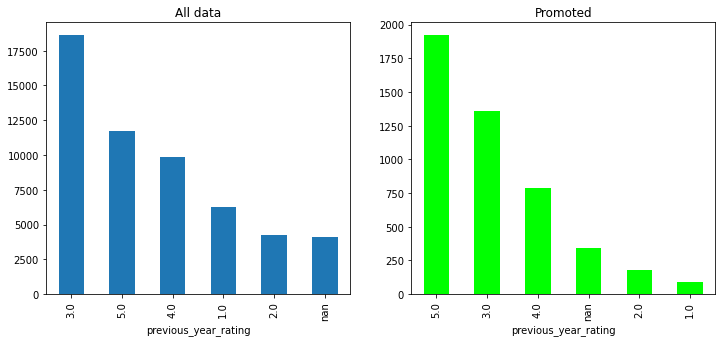

----------------------------------------------------------------------------------------------------


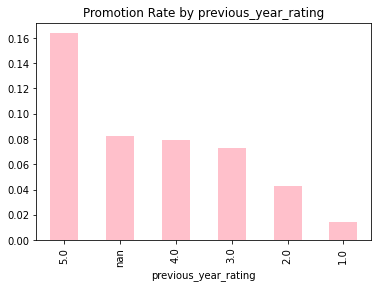

--------------------------------------------------
+----------------------+----------------+
| previous_year_rating | Promotion Rate |
+----------------------+----------------+
|         5.0          |     0.164      |
|         nan          |     0.082      |
|         4.0          |     0.079      |
|         3.0          |     0.073      |
|         2.0          |     0.043      |
|         1.0          |     0.014      |
+----------------------+----------------+


In [ ]:
EDA_categorical('previous_year_rating')

### Exploring Missing Value

In [ ]:
train_data[train_data.previous_year_rating.isna()].head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
23,71177,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,74759,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,26599,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0


In [ ]:
print('All Missing values have one year of service ')
print('-'*50)

print(f"Number of Missing values: {train_data[train_data.previous_year_rating.isna()].shape[0]} ")

print(f"Unique values for corresponding Length of Service: \n", train_data[train_data.previous_year_rating.isna()].length_of_service.value_counts(dropna=False))

All Missing values have one year of service 
--------------------------------------------------
Number of Missing values: 4124 
Unique values for corresponding Length of Service: 
 1    4124
Name: length_of_service, dtype: int64


In [ ]:
print('Ratings Frequency for all employees with 1 year of service')
print('-'*50)

# All length of service = 1
train_data[train_data.length_of_service == 1].previous_year_rating.value_counts(dropna=False)

Ratings Frequency for all employees with 1 year of service
--------------------------------------------------


NaN    4124
3.0     158
4.0     114
5.0      64
1.0      44
2.0      43
Name: previous_year_rating, dtype: int64

In [ ]:
print('Ratings Frequency for all employees')
print('-'*50)

# All data
train_data.previous_year_rating.value_counts(dropna=False)

Ratings Frequency for all employees
--------------------------------------------------


3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
NaN     4124
Name: previous_year_rating, dtype: int64

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [ ]:
print('Ratings Frequency for all employees who were promoted')
print('-'*50)

# Promoted data
train_data[train_data.is_promoted == 1].previous_year_rating.value_counts(dropna=False)

Ratings Frequency for all employees who were promoted
--------------------------------------------------


5.0    1921
3.0    1355
4.0     784
NaN     339
2.0     181
1.0      88
Name: previous_year_rating, dtype: int64

In [ ]:
print('Frequency of ratings for employees who were not promoted')
print('-'*50)

# Not promoted data
train_data[train_data.is_promoted == 0].previous_year_rating.value_counts(dropna=False)

Frequency of ratings for employees who were not promoted
--------------------------------------------------


3.0    17263
5.0     9820
4.0     9093
1.0     6135
2.0     4044
NaN     3785
Name: previous_year_rating, dtype: int64

In [ ]:
print('Number of employees with Length of sevice = 1 and Ratings != NA')
print('-'*50, end='\n\n')

# All length = 1 and not NA
print('No of data points with lenght service = 1 and not Null previous year rating:',
      train_data[(train_data.length_of_service == 1) & (train_data.previous_year_rating.notna())].shape[0]
      )

print('Percentage of total data:', 
      round((train_data[(train_data.length_of_service == 1) & 
                        (train_data.previous_year_rating.notna())
                        ].shape[0]/train_data.shape[0])
      , 3)*100,
      '%'
      )

Number of employees with Length of sevice = 1 and Ratings != NA
--------------------------------------------------

No of data points with lenght service = 1 and not Null previous year rating: 423
Percentage of total data: 0.8 %


In [ ]:
print('Number of employees with missing rating but length of service > 1')
print('-'*50)

train_data[(train_data.previous_year_rating.isna()) & (train_data.length_of_service > 1)].shape[0]
#['is_promoted'].value_counts(dropna=False)

Number of employees with missing rating but length of service > 1
--------------------------------------------------


0

### Observations
- Rating range is [1,5]
- Apparently good indicator, rate of promotion for each category does not follow natural frequency. Naturally 5 rating guys have highest promotions (both number and rate). Missing values are next, this could be due to the fact that most new hireings are at junior levels and hence comparitively easily promoted.
- Missing values are for cases where length of service is only one year. Checking for all cases with lenght of service $=1$, we see that after Missing values the next highest rating $=3$. For whole data set mode $=3$. 
- It is not possible to have previous years rating after only serving $1$ year. The amount of such data is miniscule ($\approx 0.8\%$). Thus such data will also be imputed similar to missing value.
- Hence we are going impute Missing values following either of the following techniques:
    - with mode $=3$: For when `length_of_service` $>1$
    - since Nan carries enough information, let it be a category for when `length_of_service` $=1$.
    <center>OR</center>
    - With mode $=3$ for all data with missing record for `previous_year_rating`
    - create an NaN indicator variable for `previous_year_rating`.

## `length_of_service`

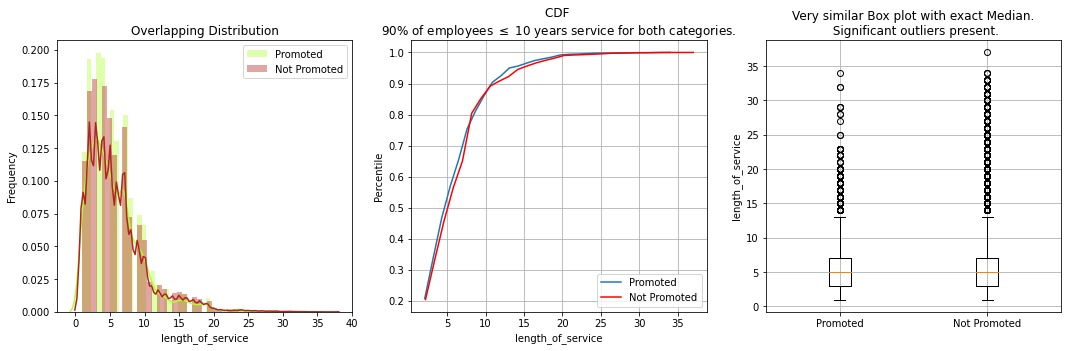

----------------------------------------------------------------------------------------------------
+-------+----------+--------------+
| Stats | Promoted | Not Promoted |
+-------+----------+--------------+
| count |  4668.0  |   50140.0    |
|  mean |   5.72   |     5.88     |
|  std  |   4.01   |     4.29     |
|  min  |   1.0    |     1.0      |
|  25%  |   3.0    |     3.0      |
|  50%  |   5.0    |     5.0      |
|  75%  |   7.0    |     7.0      |
|  max  |   34.0   |     37.0     |
+-------+----------+--------------+


In [ ]:
EDA_continuous('length_of_service', title_1='Overlapping Distribution', 
               title_2=r'90% of employees $\leq$ 10 years service for both categories.',
               title_3='Very similar Box plot with exact Median.\n Significant outliers present.')

### Observation
Length of service does not appear to impact chance of promotion.

## `avg_training_score`

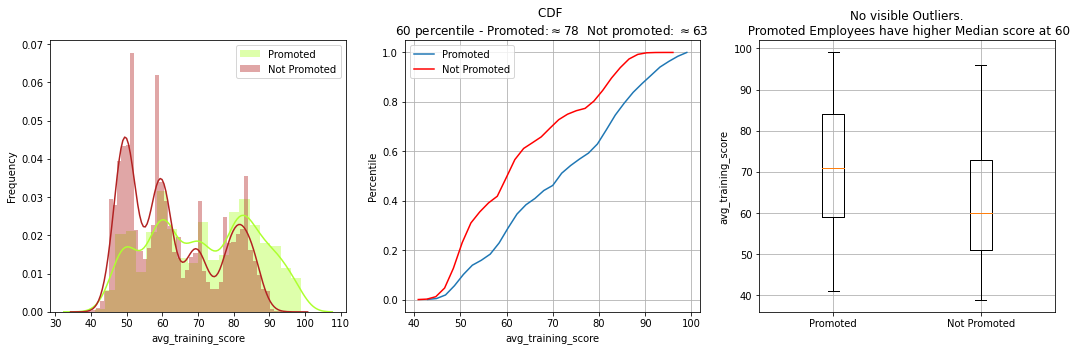

----------------------------------------------------------------------------------------------------
+-------+----------+--------------+
| Stats | Promoted | Not Promoted |
+-------+----------+--------------+
| count |  4668.0  |   50140.0    |
|  mean |  71.33   |    62.65     |
|  std  |  14.75   |    12.99     |
|  min  |   41.0   |     39.0     |
|  25%  |   59.0   |     51.0     |
|  50%  |   71.0   |     60.0     |
|  75%  |   84.0   |     73.0     |
|  max  |   99.0   |     96.0     |
+-------+----------+--------------+


In [ ]:
EDA_continuous('avg_training_score', 
               title_2=r'60 percentile - Promoted:$\approx 78$  Not promoted: $\approx 63$ ',
               title_3='No visible Outliers.\n Promoted Employees have higher Median score at 60')

### Observation
Average training score for employees those were promoted is significantly higher.

## *Q*. How does Employees from different department score in training?

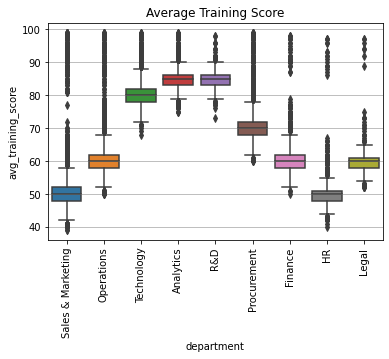

In [ ]:
sns.boxplot(x='department', y='avg_training_score', data=train_data)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Average Training Score')
plt.show()

### Observation
- High average training score generally tend to point towards higher promotion rate, for example `Analytics` has highest average trainig score along with `R&D` and is also among the higher promotion rates. But on the other hand employees from `R&D` department although score highly but has one of the lowest promotion rates.
- This indicates that getting high training score is not enough.

## *Q*. Why some employees who met $> 80\%$ KPi's criteria, but were still not promoted?

In [ ]:
# All data 'KPIs_met >80%'] = 1 grouped by 'is_promoted'
df = train_data[train_data['KPIs_met >80%'] == 1].groupby('is_promoted')\
[['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']].describe().round(3)

# display
df.loc[:, df.columns.get_level_values(1).isin(['min', 'mean', '50%', 'max'])]

no_of_trainings                 ... avg_training_score                  
                       mean  min  50%  max  ...               mean   min   50%   max
is_promoted                                 ...                                     
0                     1.218  1.0  1.0  8.0  ...             63.970  40.0  61.0  94.0
1                     1.203  1.0  1.0  6.0  ...             68.932  41.0  68.0  99.0

[2 rows x 20 columns]

In [ ]:
print('Rate of promotion by categories of awards_won for all employees meeting KPI criteria.')
print('-'*50)
# Promotion rate of all employees met KPi criteria
# and won award
train_data[train_data['KPIs_met >80%'] == 1].groupby('awards_won?')['is_promoted'].value_counts() / train_data[train_data['KPIs_met >80%'] == 1].groupby('awards_won?')['is_promoted'].count()

Rate of promotion by categories of awards_won for all employees meeting KPI criteria.
--------------------------------------------------


awards_won?  is_promoted
0            0              0.840646
             1              0.159354
1            0              0.613993
             1              0.386007
Name: is_promoted, dtype: float64

### Observation

- Employees who met KPI criteria and were promoted have higher average training score (both median and mean) compared to those not promoted.
- Among the employees who met KPI criteria, there is clearly higher chances of promotion ($\approx 39\%$) for those who won awards compared to those who did not($\approx 16\%$).


## *Q*. Why some employees were not promoted even after getting award?

In [ ]:
print('Only those Employees who won awards')
print('-'*50, end='\n\n')

train_data[train_data['awards_won?'] == 1].groupby('is_promoted')[['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']].agg(['mean', 'min', 'median', 'max']).round(3)

Only those Employees who won awards
--------------------------------------------------



no_of_trainings                 ... avg_training_score               
                       mean min median max  ...               mean min median max
is_promoted                                 ...                                  
0                     1.262   1      1   6  ...             62.806  42     60  90
1                     1.174   1      1   4  ...             78.354  43     82  99

[2 rows x 20 columns]

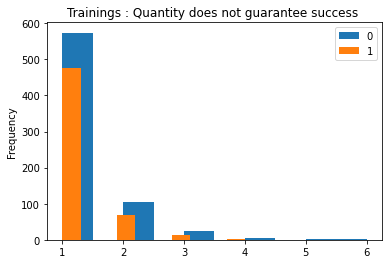

In [ ]:
train_data[train_data['awards_won?'] == 1].groupby('is_promoted')['no_of_trainings'].plot(kind='hist')
plt.title('Trainings : Quantity does not guarantee success ')
plt.legend()

plt.show()

### Observation
- Higher Quantity of trainings does not guarantee success.
- Those who were promoted have comparatively higher `previous_year_rating`.
- Average training score is considerably higher for those who were promoted. 
    - Median for promoted = 82
    - Median for not promoted = 60

## *Q*. Why some employees with $5 \space \star$ ratings were not promoted?

In [ ]:
star = u'\u2605'
print(f'Promotion rate for 5 {star} employees:')
print(train_data[train_data.previous_year_rating == 5].groupby('is_promoted')['employee_id'].count()/ train_data[train_data.previous_year_rating == 5].shape[0])

print()
print('-'*50, end='\n\n')
train_data[train_data.previous_year_rating == 5].groupby('is_promoted')[['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']].agg(['mean', 'min', 'median', 'max']).round(3)

Promotion rate for 5 ★ employees:
is_promoted
0    0.836385
1    0.163615
Name: employee_id, dtype: float64

--------------------------------------------------



no_of_trainings                 ... avg_training_score               
                       mean min median max  ...               mean min median max
is_promoted                                 ...                                  
0                     1.190   1      1   7  ...             62.174  40     59  93
1                     1.188   1      1   5  ...             72.001  43     72  99

[2 rows x 16 columns]

### Observation
Average training score is the deciding factor for those who got $5 \star$ rating  yet did not get promoted.

## <center> Summary of EDA </center>
- **No duplicate** records.
- Only $\approx 9\%$ employees are promoted.
- Employees from Technology `department` have highest promotion rate and those from HR and Legal rank the lowest.
- `region` has **High cardinality**; 34 categories. We will impute them with **rare_region** keyword. Does not appear to be a strong predictor.
- `education`: Masters degree holder has best chance of promotion. It has $\approx 4 \%$ **Missing** values; missing data will be imputed with **missing** keyword.
- `gender`: No evident gender bias.
- `recruitment_channel`: **referred** candidate has the highest rate of promotion and is considerably higher compared to other two categories. Good discriminatory power.
- `KPIs_met>80%`: who have met  >80%  KPI's have much higher rate of being promoted ( $\approx 4$  times) compared to those who have not. Expected to be strong predictors.
- `awards_won?`: Employees who won awards have much higher chance of being promoted($\approx 44\%$) compared to those who have not ($\approx 8\%$)
- `no_of_trainings`: Quantity of trainings does not seem to have any direct impact on the outcome.
- `age`: not consequential.
- `previous_year_rating`:
    - Employees with $5 \space \star$ rating nturally has highest rate of promotion
    - All the missing values have `length_of_service` $=1$.  $\approx 8$% Missing values.
    - It is not possible to have previous years rating after only serving  1  year. The amount of such data is miniscule ( $\approx 0.8$%). Thus such data will also be imputed similar to missing value.
    - Impute missing value with mode $=3$ and create an **indicator variable** for the missing values.

- `length_of_service`: Length of service does not appear to impact chance of promotion.

- `avg_training_score`: Average training score for employees those were promoted is significantly higher.

- Although higher average training score ups the chance of promotion, but for employees of certain departments  having **highest training score does not necessarily translate to higher chances of promotion**, like `R&D`. In fact `R&D` with highest average training score is also among the bottom departments for rate of promotion.

- **Even** if the employees **meet the KPIs criteria**, but a comparitively **lower** average **training score** will **not** be enough to get **promoted**.

- Only winning awards will not be enough; to get promoted will also need higher previous year rating and high average tarining score.

- A combination of meeting KPIs criteria, high average training score, winning of awards is absolutely neccessary to get promoted. Add to it a Masters degree and chances of promotion become considerably buoyant.

# Data Preprocessing

- Missing value imputation
- Rare category
- Feature Transformation and Scaling

## Split Train and Validate Set
 Split ratio $=$ train ($80$) $:$ validate ($20$)

In [ ]:
X = train_data.copy()

In [ ]:
train_index, validate_index = train_test_split(X.is_promoted, test_size=0.2, stratify=X.is_promoted, random_state=1)
train_index, validate_index = train_index.index, validate_index.index

In [ ]:
del train_data